In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import os

In [2]:
root = "../data/"
filename = 'javi_measurements.csv' 
data_file = os.path.join(root, filename)
!head $data_file

In [3]:
columns = 'Medidor,Número de serial,Sello de tiempo del medidor,Tipo de registro,Historial de glucosa(mg/dL),Escaneo de glucosa(mg/dL),Insulina de acción rápida no numérica,Insulina de acción rápida (unidades),Alimento no numérico,Carbohidratos (gramos),Carbohidratos (porciones),Insulina de acción larga no numérica,Insulina de acción larga (unidades),Notas,Tira reactiva para glucosa(mg/dL),Cuerpos cetónicos(mmol/L),Comida e insulina (unidades),Insulina de corrección (unidades),Insulina del cambio de usuario (unidades)'
columns = columns.split(',')

df = pd.read_csv(data_file, sep=',', header=None, names=columns, low_memory=False)
df.drop(df.index[0], inplace=True)
df.head()

,Medidor,Número de serial,Sello de tiempo del medidor,Tipo de registro,Historial de glucosa(mg/dL),Escaneo de glucosa(mg/dL),Insulina de acción rápida no numérica,Insulina de acción rápida (unidades),Alimento no numérico,Carbohidratos (gramos),Carbohidratos (porciones),Insulina de acción larga no numérica,Insulina de acción larga (unidades),Notas,Tira reactiva para glucosa(mg/dL),Cuerpos cetónicos(mmol/L),Comida e insulina (unidades),Insulina de corrección (unidades),Insulina del cambio de usuario (unidades)
1,LibreLink,2b3982f5-45fa-4396-8726-78a4651e35cb,06-06-2017 5:40 pm,0,156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LibreLink,2b3982f5-45fa-4396-8726-78a4651e35cb,06-06-2017 5:55 pm,0,159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LibreLink,2b3982f5-45fa-4396-8726-78a4651e35cb,06-06-2017 6:10 pm,0,170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LibreLink,2b3982f5-45fa-4396-8726-78a4651e35cb,06-06-2017 6:25 pm,0,164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,LibreLink,2b3982f5-45fa-4396-8726-78a4651e35cb,06-06-2017 6:40 pm,0,147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.describe()

,Medidor,Número de serial,Sello de tiempo del medidor,Tipo de registro,Historial de glucosa(mg/dL),Escaneo de glucosa(mg/dL),Insulina de acción rápida no numérica,Insulina de acción rápida (unidades),Alimento no numérico,Carbohidratos (gramos),Carbohidratos (porciones),Insulina de acción larga no numérica,Insulina de acción larga (unidades),Notas,Tira reactiva para glucosa(mg/dL),Cuerpos cetónicos(mmol/L),Comida e insulina (unidades),Insulina de corrección (unidades),Insulina del cambio de usuario (unidades)
count,103357,103357,103357,103357,93657,9693,0.0,4,0.0,0.0,0.0,0.0,3,0.0,0.0,0.0,0.0,0.0,0.0
unique,2,8,83564,3,457,405,0.0,4,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0
top,FreeStyle LibreLink,c5f89737-15cc-4361-8788-d4c019a08f78,09-28-2017 6:40 am,0,173,75,NaN,"6,0",NaN,NaN,NaN,NaN,"10,0",NaN,NaN,NaN,NaN,NaN,NaN
freq,52067,40897,4,93657,480,66,NaN,1,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
dfs = df[['Sello de tiempo del medidor', 'Historial de glucosa(mg/dL)', 'Escaneo de glucosa(mg/dL)']]
dfs.columns = ['timestamp', 'aut_record', 'man_record']

In [17]:
dfs.head()

,timestamp,aut_record,man_record
1,06-06-2017 5:40 pm,156,NaN
2,06-06-2017 5:55 pm,159,NaN
3,06-06-2017 6:10 pm,170,NaN
4,06-06-2017 6:25 pm,164,NaN
5,06-06-2017 6:40 pm,147,NaN


In [18]:
dfs = dfs.dropna(inplace=False, subset=['aut_record'])

In [19]:
dfs.head()

,timestamp,aut_record,man_record
1,06-06-2017 5:40 pm,156,NaN
2,06-06-2017 5:55 pm,159,NaN
3,06-06-2017 6:10 pm,170,NaN
4,06-06-2017 6:25 pm,164,NaN
5,06-06-2017 6:40 pm,147,NaN


In [31]:
dfs.aut_record = dfs.aut_record.values.astype(np.int)

In [32]:
dfs.aut_record.values[:100]

array([156, 159, 170, 164, 147, 148, 156, 160, 175, 183, 176, 172, 178,
       177, 186, 203, 213, 219, 222, 232, 248, 251, 241, 227, 212, 210,
       224, 240, 250, 254, 263, 267, 269, 272, 262, 251, 244, 237, 230,
       225, 232, 229, 210, 206, 204, 200, 199, 200, 198, 194, 197, 197,
       190, 195, 210, 236, 272, 306, 314, 279, 243, 209, 191, 196, 192,
       171, 152, 145, 140, 125, 112, 106, 119, 156, 192, 214, 221, 218,
       220, 222, 221, 221, 222, 222, 235, 250, 260, 267, 258, 228, 196,
       169, 154, 145, 137, 134, 139, 152, 161, 160])

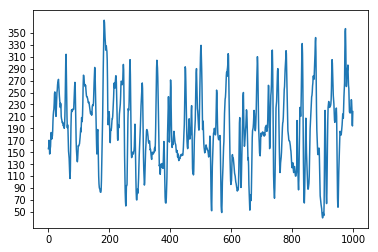

In [39]:
plt.figure()
plt.plot(dfs.aut_record.values[:1000])
yaxis = np.arange(50, 360, step=20)
plt.yticks(yaxis, yaxis)
plt.show()